**Pemeriksaan Struktur dan mising values**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', 20)
plt.style.use('seaborn-v0_8-whitegrid')

train_path = "dataset/SemgHandSubjectCh2_TRAIN.ts"
test_path  = "dataset/SemgHandSubjectCh2_TEST.ts"

def load_ts_file(file_path):
    encodings = ['utf-8', 'latin-1'] 
    data = []
    
    for enc in encodings:
        try:
            with open(file_path, 'r', encoding=enc) as file:
                is_data = False
                for line in file:
                    line = line.strip()
                    if not line or line.startswith(('#', '%')): continue
                        
                    if line.lower().startswith("@data"):
                        is_data = True
                        continue
                    
                    if not is_data: continue
                    if ':' in line:
                        parts = line.split(':')
                        features_str = parts[0] 
                        label_str = parts[-1]   
                        
                        values = features_str.split(',')
                        values.append(label_str) 
                    else:
                        values = line.split(',')
                        
                    data.append(values)
            break 
        except UnicodeDecodeError:
            continue
            
    if not data:
        raise ValueError(f"Gagal membaca file {file_path}.")

    df = pd.DataFrame(data)

    X = df.iloc[:, :-1].astype(float) 
    y = df.iloc[:, -1] 
    
    return X, y

try:
    X_train, y_train = load_ts_file(train_path)
    X_test, y_test = load_ts_file(test_path)
    
    print("1. PEMERIKSAAN STRUKTUR DATA")
    print(f"Shape (X_train): {X_train.shape}")
    # if X_train.shape[1] == 1500:
    #     print("✅ STRUKTUR BENAR: 1500 Fitur terdeteksi.")
    # else:
    #     print(f"⚠️ PERINGATAN: Jumlah fitur {X_train.shape[1]} (Harapan: 1500).")

    print(f"Shape (y_train): {y_train.shape}")
    print("-" * 20)
    print("Contoh 5 baris pertama data latih (Subset kolom awal):")
    display(X_train.iloc[:, :10].head())

    print("2. PEMERIKSAAN KUALITAS DATA")

    null_counts = X_train.isnull().sum().sum()
    print(f"Total Missing Values (NaN): {null_counts}")
    unique_labels = y_train.unique()
    print(f"Label Kelas Unik: {sorted(unique_labels)}")

except Exception as e:
    print(f"\n❌ ERROR: {e}")

1. PEMERIKSAAN STRUKTUR DATA
Shape (X_train): (450, 1500)
Shape (y_train): (450,)
--------------------
Contoh 5 baris pertama data latih (Subset kolom awal):


,0,1,2,3,4,5,6,7,8,9
0,4.727125,2.797737,3.636139,2.746511,0.971014,2.210892,3.344643,0.584697,2.450385,2.185442
1,3.710899,2.427400,1.624620,0.835390,1.268488,1.498597,0.799706,1.259650,0.412866,0.928109
2,3.691784,7.646312,4.573417,6.589344,1.606932,5.105149,3.388973,6.454872,2.436382,6.159850
3,3.659098,1.348780,2.660728,1.951933,1.336938,2.802475,2.054903,2.298930,1.007570,0.718818
4,6.352287,3.688895,5.923694,4.516546,3.978157,4.106319,4.735417,5.000411,3.958317,3.482435


2. PEMERIKSAAN KUALITAS DATA
Total Missing Values (NaN): 0
Label Kelas Unik: ['1', '2', '3', '4', '5']


**Statistik & Visualisasi Spektrum**

3. STATISTIK DESKRIPTIF GLOBAL
 
Nilai Minimum Global : 0.0052
Nilai Maksimum Global: 2238.5732
Rata-rata Global     : 16.8005
Std Deviasi Global   : 18.0148
👉 Insight: Rentang nilai bervariasi luas. Normalisasi (MinMax/Standard) SANGAT DISARANKAN nanti.
 
4. VISUALISASI SPEKTRUM PER KELAS (SUBJEK)


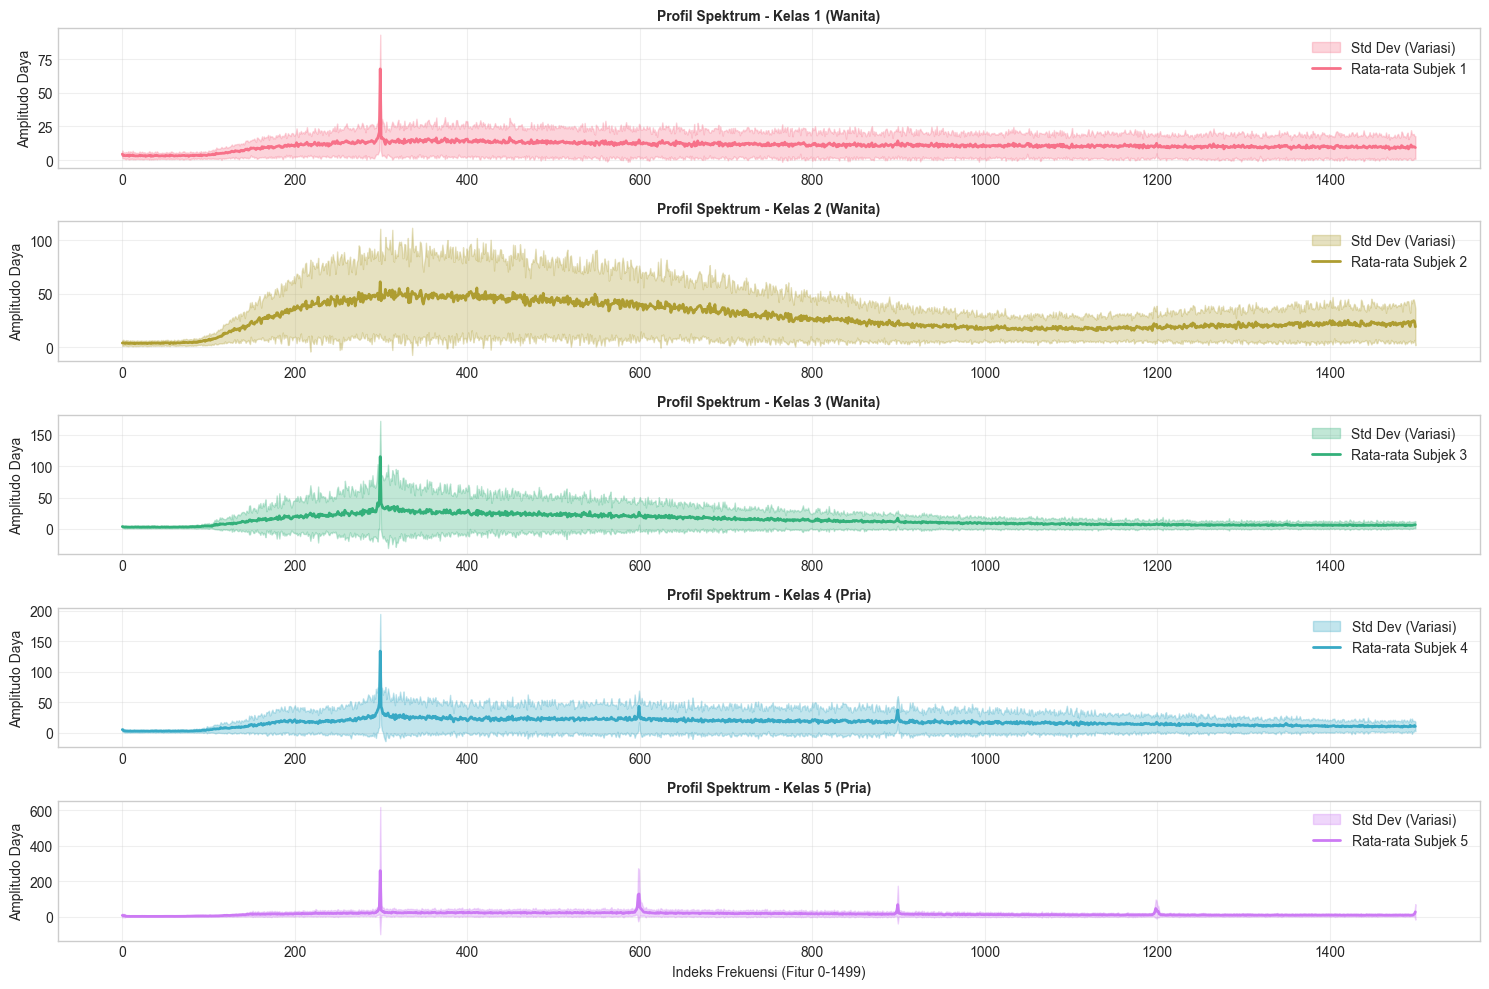

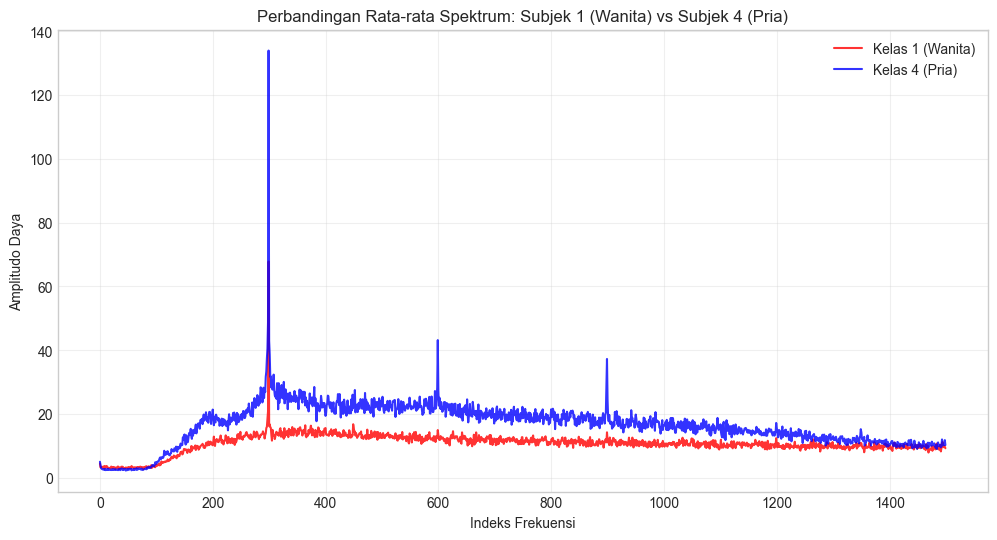

In [ ]:
print("3. STATISTIK DESKRIPTIF GLOBAL")

print(" ")
print(f"Nilai Minimum Global : {X_train.min().min():.4f}")
print(f"Nilai Maksimum Global: {X_train.max().max():.4f}")
print(f"Rata-rata Global     : {X_train.mean().mean():.4f}")
print(f"Std Deviasi Global   : {X_train.std().mean():.4f}")

if X_train.max().max() > 10 or X_train.min().min() < 0:
    print("👉 Insight: Rentang nilai bervariasi luas. Normalisasi (MinMax/Standard) SANGAT DISARANKAN nanti.")
else:
    print("👉 Insight: Data tampaknya sudah dalam skala kecil.")

print(" ")
print("4. VISUALISASI SPEKTRUM PER KELAS (SUBJEK)")

classes = sorted(y_train.unique())
colors = sns.color_palette("husl", len(classes))

plt.figure(figsize=(15, 10))

# Loop untuk setiap kelas (Subjek)
for i, label in enumerate(classes):
    # Ambil semua sampel milik kelas tersebut
    # Kita gunakan boolean indexing
    idx = y_train[y_train == label].index
    class_data = X_train.loc[idx]
    
    # Hitung Rata-rata Spektrum & Standar Deviasi per titik frekuensi
    mean_spectrum = class_data.mean(axis=0)
    std_spectrum = class_data.std(axis=0)
    
    # Plotting pada Subplot (biar rapi 5 baris ke bawah)
    plt.subplot(len(classes), 1, i+1)
    
    # Plot area standar deviasi (Shading)
    x_axis = range(len(mean_spectrum))
    plt.fill_between(x_axis, 
                     mean_spectrum - std_spectrum, 
                     mean_spectrum + std_spectrum, 
                     color=colors[i], alpha=0.3, label='Std Dev (Variasi)')
    
    # Plot garis rata-rata
    plt.plot(x_axis, mean_spectrum, color=colors[i], linewidth=2, label=f'Rata-rata Subjek {label}')
    
    plt.title(f"Profil Spektrum - Kelas {label} ({'Wanita' if int(label) <= 3 else 'Pria'})", fontsize=10, fontweight='bold')
    plt.ylabel("Amplitudo Daya")
    if i == len(classes)-1:
        plt.xlabel("Indeks Frekuensi (Fitur 0-1499)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Plot Overlay (Tumpuk) untuk membandingkan Pria vs Wanita ---
plt.figure(figsize=(12, 6))
plt.title("Perbandingan Rata-rata Spektrum: Subjek 1 (Wanita) vs Subjek 4 (Pria)")

# Ambil rata-rata Kelas 1
mean_c1 = X_train.loc[y_train == '1'].mean(axis=0)
# Ambil rata-rata Kelas 4
mean_c4 = X_train.loc[y_train == '4'].mean(axis=0)

plt.plot(mean_c1, label='Kelas 1 (Wanita)', color='red', alpha=0.8)
plt.plot(mean_c4, label='Kelas 4 (Pria)', color='blue', alpha=0.8)
plt.legend()
plt.xlabel("Indeks Frekuensi")
plt.ylabel("Amplitudo Daya")
plt.grid(True, alpha=0.3)
plt.show()

**Hasil Temuan**

Berdasarkan hasil analisis statistik deskriptif, ditemukan perbedaan yang sangat ekstrem antara nilai minimum sebesar 0,005 dan nilai maksimum sebesar 2238,57, dengan nilai rata-rata (mean) hanya sebesar 16,8. Kondisi ini menunjukkan bahwa sebagian besar data berada pada nilai yang rendah, sementara hanya sedikit data yang memiliki nilai sangat tinggi, sehingga distribusi data bersifat condong (skewed). Karakteristik tersebut mengindikasikan adanya frekuensi dengan energi yang sangat besar dibandingkan frekuensi lainnya. Oleh karena itu, pada tahap preprocessing data diperlukan proses scaling, seperti Min-Max Scaling atau Standard Scaling, untuk menormalkan rentang nilai agar model dapat melakukan pembelajaran secara lebih efektif dan tidak terpengaruh oleh perbedaan skala yang ekstrem.


5. DISTRIBUSI LABEL KELAS


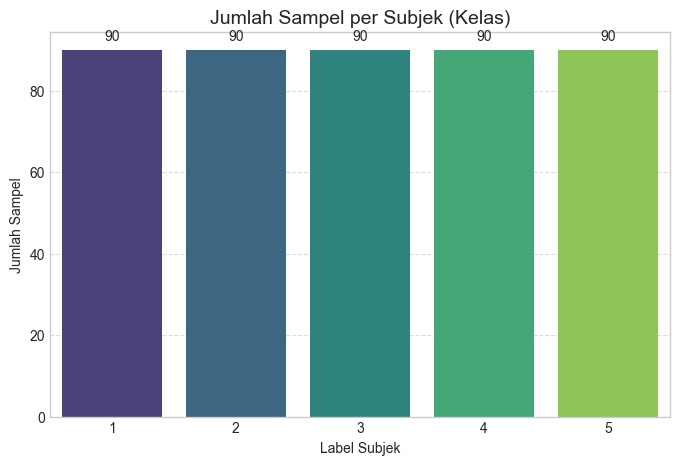

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("5. DISTRIBUSI LABEL KELAS")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train, palette="viridis", hue=y_train, legend=False)
plt.title("Jumlah Sampel per Subjek (Kelas)", fontsize=14)
plt.xlabel("Label Subjek")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

7. HEATMAP KORELASI (SUBSET 50 FITUR PERTAMA)
👉 Mengambil 50 fitur pertama saja agar visualisasi tidak berat/lag.


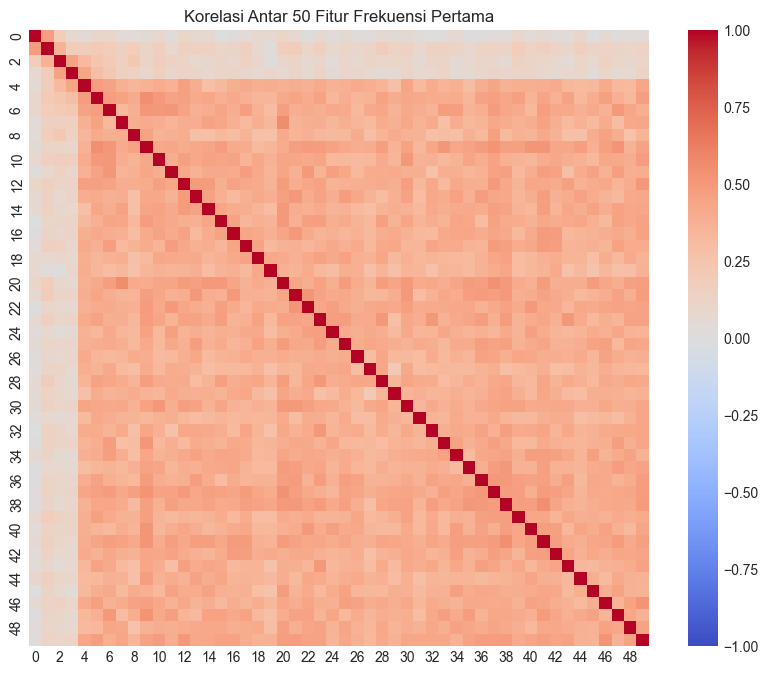

In [ ]:
print("7. HEATMAP KORELASI (SUBSET 50 FITUR PERTAMA)")
print("👉 Mengambil 50 fitur pertama saja agar visualisasi tidak berat/lag.")

subset_features = X_train.iloc[:, :50]
corr_matrix = subset_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Korelasi Antar 50 Fitur Frekuensi Pertama")
plt.show()

8. VISUALISASI 2D (PCA & t-SNE)
PCA selesai. Variance Explained: 54.76%
 t-SNE selesai.


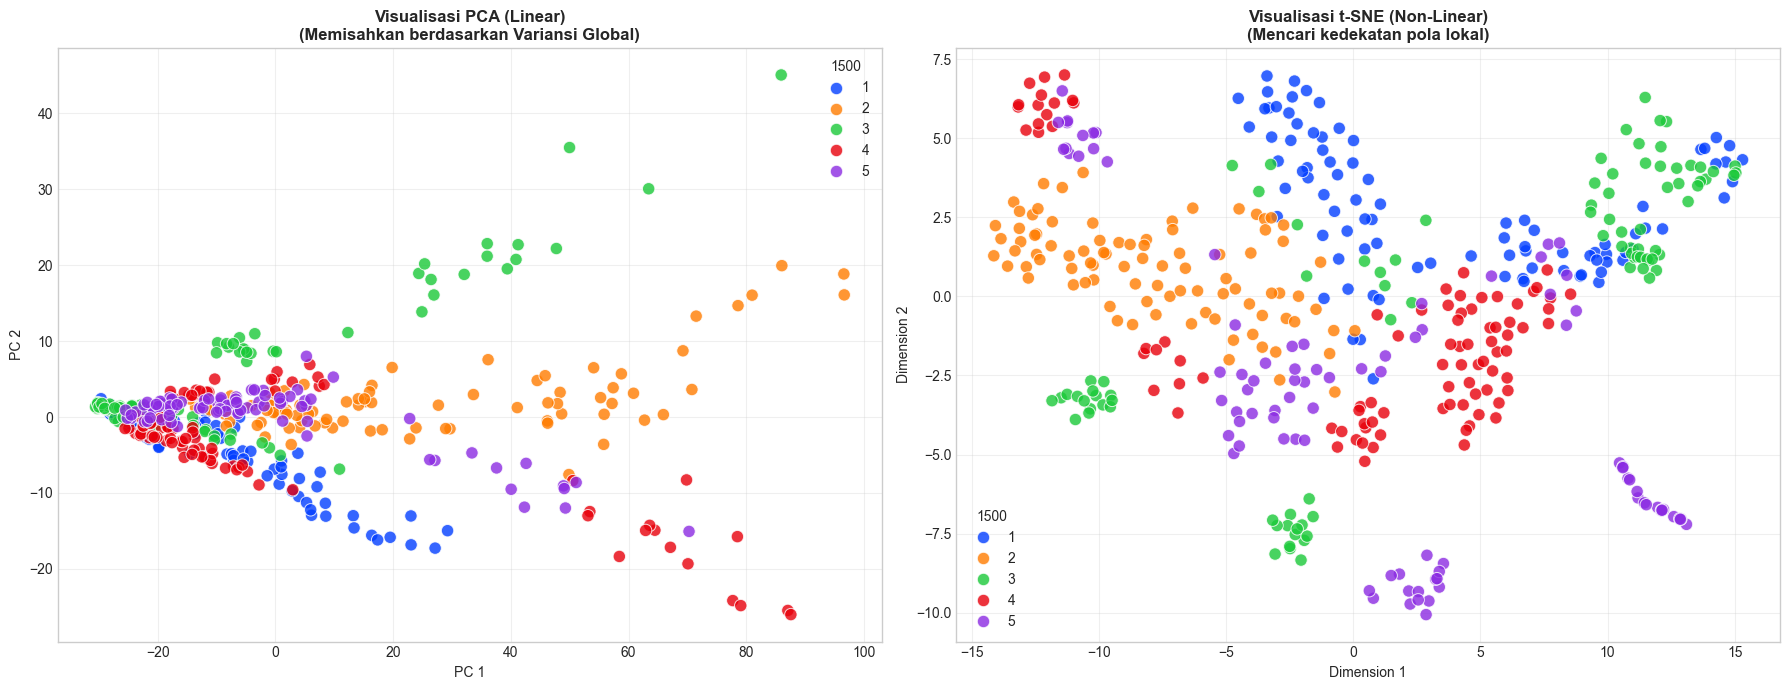

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("8. VISUALISASI 2D (PCA & t-SNE)")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA selesai. Variance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
tsne = TSNE(n_components=2, random_state=42, perplexity=30) 
X_tsne = tsne.fit_transform(X_scaled)
print(" t-SNE selesai.")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette="bright", ax=axes[0], s=80, alpha=0.8)
axes[0].set_title("Visualisasi PCA (Linear)\n(Memisahkan berdasarkan Variansi Global)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[0].grid(True, alpha=0.3)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, palette="bright", ax=axes[1], s=80, alpha=0.8)
axes[1].set_title("Visualisasi t-SNE (Non-Linear)\n(Mencari kedekatan pola lokal)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Ditemukan 23 data yang dicurigai sebagai OUTLIER.
   (Sekitar 5.11% dari total data)

 Distribusi Outlier per Subjek:
   - Subjek 2: 9 sampel terdeteksi aneh.
   - Subjek 3: 3 sampel terdeteksi aneh.
   - Subjek 4: 10 sampel terdeteksi aneh.
   - Subjek 5: 1 sampel terdeteksi aneh.


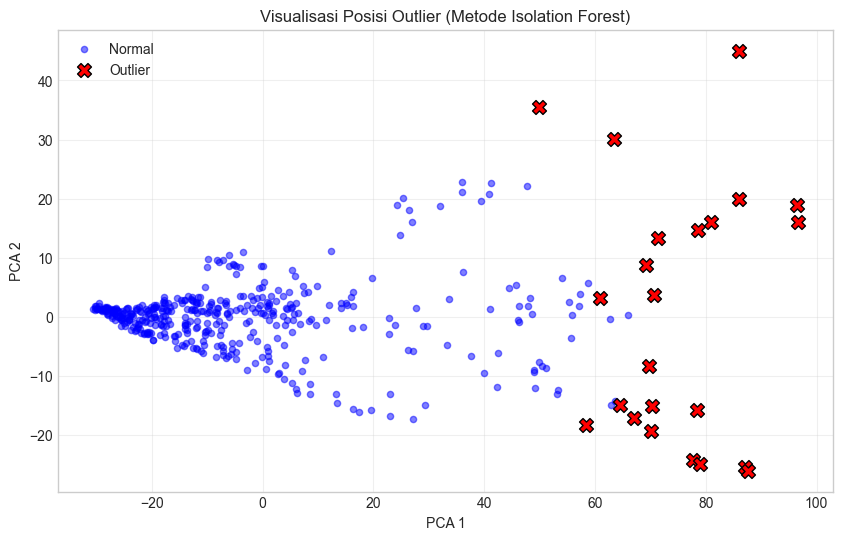

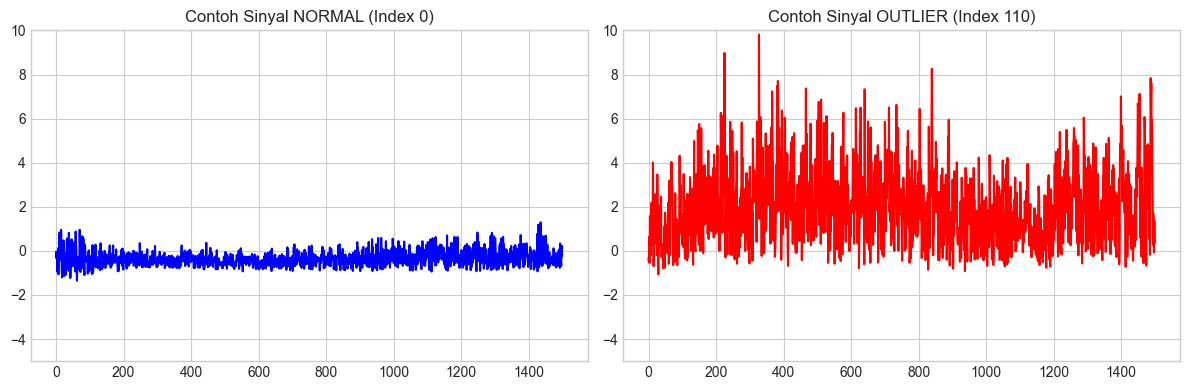

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    if 'X_train_final' not in locals():
        X_train_check = np.load('processed_data/X_train_final.npy')
        y_train_check = np.load('processed_data/y_train_final.npy')
    else:
        X_train_check = X_train_final
        y_train_check = y_train_final
except Exception as e:
    print("Data tidak ditemukan. Pastikan folder processed_data ada.")

iso = IsolationForest(contamination=0.05, random_state=42) 
y_outliers = iso.fit_predict(X_train_check)

outlier_index = np.where(y_outliers == -1)
total_outliers = len(outlier_index[0])

print(f"Ditemukan {total_outliers} data yang dicurigai sebagai OUTLIER.")
print(f"   (Sekitar {total_outliers/len(X_train_check)*100:.2f}% dari total data)")

outlier_labels = y_train_check[outlier_index]
unique, counts = np.unique(outlier_labels, return_counts=True)
label_names = ['Subjek 1', 'Subjek 2', 'Subjek 3', 'Subjek 4', 'Subjek 5']

print("\n Distribusi Outlier per Subjek:")
for u, c in zip(unique, counts):
    print(f"   - {label_names[u]}: {c} sampel terdeteksi aneh.")

pca = PCA(n_components=2)
X_pca_outlier = pca.fit_transform(X_train_check)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_outlier[y_outliers == 1, 0], X_pca_outlier[y_outliers == 1, 1], 
            c='blue', label='Normal', alpha=0.5, s=20)
plt.scatter(X_pca_outlier[y_outliers == -1, 0], X_pca_outlier[y_outliers == -1, 1], 
            c='red', label='Outlier', edgecolor='black', s=100, marker='X')

plt.title("Visualisasi Posisi Outlier (Metode Isolation Forest)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if total_outliers > 0:
    idx_sample_outlier = outlier_index[0][0] # Ambil outlier pertama
    idx_sample_normal = np.where(y_outliers == 1)[0][0] # Ambil normal pertama
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(X_train_check[idx_sample_normal], color='blue')
    plt.title(f"Contoh Sinyal NORMAL (Index {idx_sample_normal})")
    plt.ylim(-5, 10) # Limit visual agar sebanding (sesuaikan jika perlu)

    plt.subplot(1, 2, 2)
    plt.plot(X_train_check[idx_sample_outlier], color='red')
    plt.title(f"Contoh Sinyal OUTLIER (Index {idx_sample_outlier})")
    plt.ylim(-5, 10) 
    
    plt.tight_layout()
    plt.show()